In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_path = "/content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/preprocessed-dataset"

X_train = pd.read_csv(os.path.join(base_path, "X_train.csv"))
X_val   = pd.read_csv(os.path.join(base_path, "X_val.csv"))
X_test  = pd.read_csv(os.path.join(base_path, "X_test.csv"))

y_train = pd.read_csv(os.path.join(base_path, "y_train.csv")).squeeze()
y_val   = pd.read_csv(os.path.join(base_path, "y_val.csv")).squeeze()
y_test  = pd.read_csv(os.path.join(base_path, "y_test.csv")).squeeze()

print("Shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  " y_test: ", y_test.shape)

Shapes:
X_train: (4930, 23)  y_train: (4930,)
X_val:   (1056, 23)  y_val:   (1056,)
X_test:  (1057, 23)  y_test:  (1057,)


In [3]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    log_loss
)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Return a dict of useful metrics for model comparison."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy    = accuracy_score(y_true, y_pred)
    precision   = precision_score(y_true, y_pred, zero_division=0)
    recall      = recall_score(y_true, y_pred, zero_division=0)
    f1          = f1_score(y_true, y_pred, zero_division=0)
    roc_auc     = roc_auc_score(y_true, y_proba)
    pr_auc      = average_precision_score(y_true, y_proba)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    balanced_acc = (recall + specificity) / 2
    ll          = log_loss(y_true, y_proba)

    print(f"\n=== {model_name} (Test Set) ===")
    print("Accuracy:          ", round(accuracy, 4))
    print("Precision:         ", round(precision, 4))
    print("Recall (TPR):      ", round(recall, 4))
    print("F1-Score:          ", round(f1, 4))
    print("ROC-AUC:           ", round(roc_auc, 4))
    print("PR-AUC:            ", round(pr_auc, 4))
    print("Specificity (TNR): ", round(specificity, 4))
    print("Balanced Accuracy: ", round(balanced_acc, 4))
    print("Log Loss:          ", round(ll, 4))
    print("Confusion Matrix [TN FP; FN TP]:")
    print(cm)

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "Specificity": specificity,
        "Balanced-Accuracy": balanced_acc,
        "Log-Loss": ll,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
    }

results = []

#Baseline - Random Forest
rf_model_pca = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print("\nTraining baseline Random Forest (with PCA features)...")
rf_model_pca.fit(X_train, y_train)

y_pred_rf_pca       = rf_model_pca.predict(X_test)
y_pred_proba_rf_pca = rf_model_pca.predict_proba(X_test)[:, 1]

rf_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_rf_pca,
    y_proba=y_pred_proba_rf_pca,
    model_name="Random Forest (PCA, baseline)"
)
results.append(rf_metrics)

# Baseline XGBoost
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb_model_pca = XGBClassifier(
    n_estimators=100,
    random_state=42,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric="logloss"
)

print("\nTraining baseline XGBoost (with PCA features)...")
xgb_model_pca.fit(X_train, y_train)

y_pred_xgb_pca       = xgb_model_pca.predict(X_test)
y_pred_proba_xgb_pca = xgb_model_pca.predict_proba(X_test)[:, 1]

xgb_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_xgb_pca,
    y_proba=y_pred_proba_xgb_pca,
    model_name="XGBoost (PCA, baseline)"
)
results.append(xgb_metrics)


Training baseline Random Forest (with PCA features)...

=== Random Forest (PCA, baseline) (Test Set) ===
Accuracy:           0.7871
Precision:          0.6429
Recall (TPR):       0.4484
F1-Score:           0.5283
ROC-AUC:            0.8219
PR-AUC:             0.6198
Specificity (TNR):  0.9098
Balanced Accuracy:  0.6791
Log Loss:           0.5049
Confusion Matrix [TN FP; FN TP]:
[[706  70]
 [155 126]]

Training baseline XGBoost (with PCA features)...

=== XGBoost (PCA, baseline) (Test Set) ===
Accuracy:           0.7569
Precision:          0.5312
Recall (TPR):       0.726
F1-Score:           0.6135
ROC-AUC:            0.8241
PR-AUC:             0.6454
Specificity (TNR):  0.768
Balanced Accuracy:  0.747
Log Loss:           0.4878
Confusion Matrix [TN FP; FN TP]:
[[596 180]
 [ 77 204]]


In [4]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

print("\n" + "=" * 70)
print("GridSearchCV Results - Random Forest")
print("=" * 70)
print("Best parameters:", grid_search_rf.best_params_)
print(f"Best CV F1 score: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_

y_pred_best_rf       = best_rf_model.predict(X_test)
y_pred_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

rf_tuned_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_best_rf,
    y_proba=y_pred_proba_best_rf,
    model_name="Random Forest (PCA, tuned)"
)
results.append(rf_tuned_metrics)


Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

GridSearchCV Results - Random Forest
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV F1 score: 0.6358

=== Random Forest (PCA, tuned) (Test Set) ===
Accuracy:           0.7777
Precision:          0.5673
Recall (TPR):       0.6904
F1-Score:           0.6228
ROC-AUC:            0.8414
PR-AUC:             0.6658
Specificity (TNR):  0.8093
Balanced Accuracy:  0.7498
Log Loss:           0.4462
Confusion Matrix [TN FP; FN TP]:
[[628 148]
 [ 87 194]]


In [5]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("\nStarting GridSearchCV for XGBoost...")
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss"
    ),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

print("\n" + "=" * 70)
print("GridSearchCV Results - XGBoost")
print("=" * 70)
print("Best parameters:", grid_search_xgb.best_params_)
print(f"Best CV F1 score: {grid_search_xgb.best_score_:.4f}")

best_xgb_model = grid_search_xgb.best_estimator_

y_pred_best_xgb       = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

xgb_tuned_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_best_xgb,
    y_proba=y_pred_proba_best_xgb,
    model_name="XGBoost (PCA, tuned)"
)
results.append(xgb_tuned_metrics)


Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

GridSearchCV Results - XGBoost
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV F1 score: 0.6316

=== XGBoost (PCA, tuned) (Test Set) ===
Accuracy:           0.7465
Precision:          0.5154
Recall (TPR):       0.7758
F1-Score:           0.6193
ROC-AUC:            0.8402
PR-AUC:             0.6654
Specificity (TNR):  0.7358
Balanced Accuracy:  0.7558
Log Loss:           0.4761
Confusion Matrix [TN FP; FN TP]:
[[571 205]
 [ 63 218]]


In [6]:
results_df = pd.DataFrame(results)
print("\nFinal model comparison:")
print(results_df)

metrics_filename = "/content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/models-ouputs/rf_xgb_pca_baseline_and_tuned_metrics.csv"
metrics_path = os.path.join(base_path, metrics_filename)

results_df.to_csv(metrics_path, index=False)

print(f"\nMetrics saved to: {metrics_path}")


Final model comparison:
                           Model  Accuracy  Precision    Recall  F1-Score  \
0  Random Forest (PCA, baseline)  0.787133   0.642857  0.448399  0.528302   
1        XGBoost (PCA, baseline)  0.756859   0.531250  0.725979  0.613534   
2     Random Forest (PCA, tuned)  0.777673   0.567251  0.690391  0.622793   
3           XGBoost (PCA, tuned)  0.746452   0.515366  0.775801  0.619318   

    ROC-AUC    PR-AUC  Specificity  Balanced-Accuracy  Log-Loss   TN   FP  \
0  0.821936  0.619828     0.909794           0.679096  0.504950  706   70   
1  0.824125  0.645360     0.768041           0.747010  0.487801  596  180   
2  0.841408  0.665837     0.809278           0.749835  0.446209  628  148   
3  0.840158  0.665407     0.735825           0.755813  0.476116  571  205   

    FN   TP  
0  155  126  
1   77  204  
2   87  194  
3   63  218  

Metrics saved to: /content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/models-ouputs/rf_xgb_pca_baseline_and_tuned_m

In [7]:
results_df[
    results_df['Model'].isin([
        'XGBoost (PCA, baseline)',
        'XGBoost (PCA, tuned)'
    ])
][['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log-Loss']].reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Log-Loss
0,"XGBoost (PCA, baseline)",0.756859,0.531250,0.725979,0.613534,0.824125,0.487801
1,"XGBoost (PCA, tuned)",0.746452,0.515366,0.775801,0.619318,0.840158,0.476116


In [8]:
results_df[
    results_df['Model'].isin([
        'Random Forest (PCA, baseline)',
        'Random Forest (PCA, tuned)'
    ])
][['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log-Loss']].reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Log-Loss
0,"Random Forest (PCA, baseline)",0.787133,0.642857,0.448399,0.528302,0.821936,0.504950
1,"Random Forest (PCA, tuned)",0.777673,0.567251,0.690391,0.622793,0.841408,0.446209


In [9]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
   """ Comprehensive model evaluation function """
   print("=" * 70)
   print(f"MODEL EVALUATION: {model_name}")
   print("=" * 70)


   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)
   roc_auc = roc_auc_score(y_true, y_pred_proba)


   print(f"\nAccuracy: {accuracy:.4f}")
   print(f"Precision: {precision:.4f}")
   print(f"Recall: {recall:.4f}")
   print(f"F1-Score: {f1:.4f}")
   print(f"ROC-AUC: {roc_auc:.4f}")

   print(f"\nConfusion Matrix:")
   cm = confusion_matrix(y_true, y_pred)
   print(cm)


   print(f"\nClassification Report:")
   print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))


   return {
       'Model': model_name,
       'Accuracy': accuracy,
       'Precision': precision,
       'Recall': recall,
       'F1-Score': f1,
       'ROC-AUC': roc_auc
   }

   # Evaluate all models
results = []
results.append(evaluate_model(y_test, y_pred_rf_pca, y_pred_proba_rf_pca, "Random Forest (PCA)"))
results.append(evaluate_model(y_test, y_pred_xgb_pca, y_pred_proba_xgb_pca, "XGBoost (PCA)"))


# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)


print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(results_df.to_string(index=False))


MODEL EVALUATION: Random Forest (PCA)

Accuracy: 0.7871
Precision: 0.6429
Recall: 0.4484
F1-Score: 0.5283
ROC-AUC: 0.8219

Confusion Matrix:
[[706  70]
 [155 126]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.91      0.86       776
       Churn       0.64      0.45      0.53       281

    accuracy                           0.79      1057
   macro avg       0.73      0.68      0.70      1057
weighted avg       0.77      0.79      0.77      1057

MODEL EVALUATION: XGBoost (PCA)

Accuracy: 0.7569
Precision: 0.5312
Recall: 0.7260
F1-Score: 0.6135
ROC-AUC: 0.8241

Confusion Matrix:
[[596 180]
 [ 77 204]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.77      0.82       776
       Churn       0.53      0.73      0.61       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.

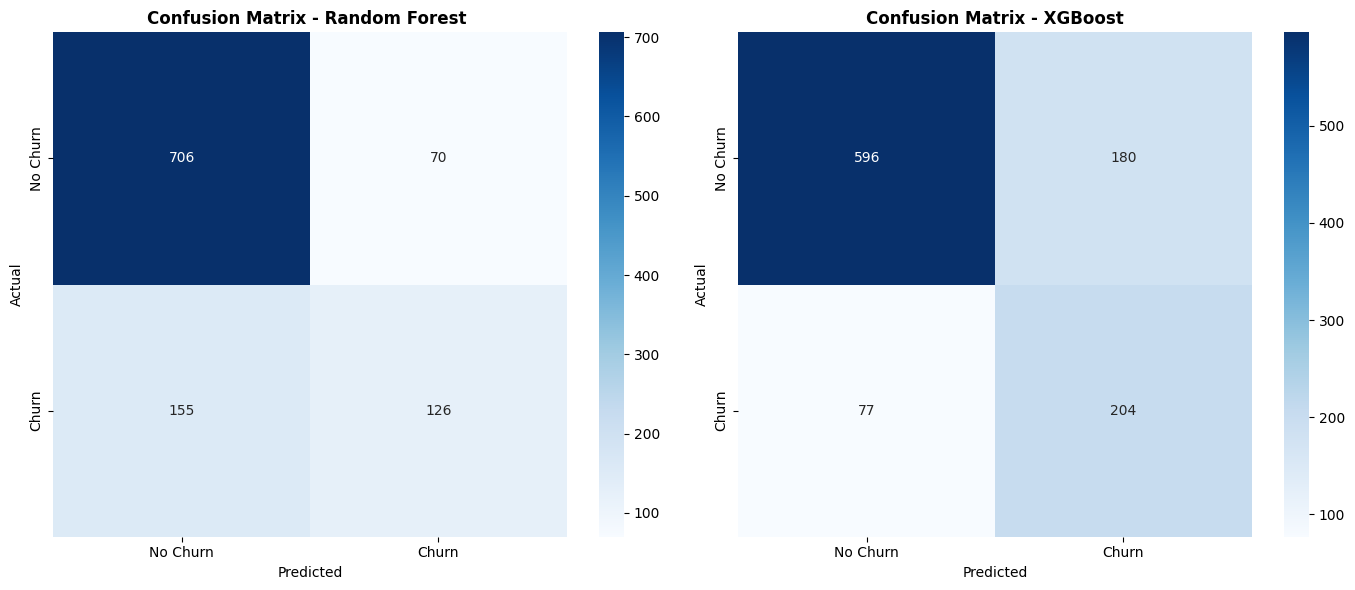

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models_data = [
   (y_pred_rf_pca, "Random Forest "),
   (y_pred_xgb_pca, "XGBoost")
]
for idx, (y_pred, model_name) in enumerate(models_data):
   cm = confusion_matrix(y_test, y_pred)
   sns.heatmap(
       cm,
       annot=True,
       fmt='d',
       cmap='Blues',
       ax=axes[idx],
       xticklabels=['No Churn', 'Churn'],
       yticklabels=['No Churn', 'Churn']
   )
   axes[idx].set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
   axes[idx].set_ylabel('Actual')
   axes[idx].set_xlabel('Predicted')


plt.tight_layout()
plt.show()


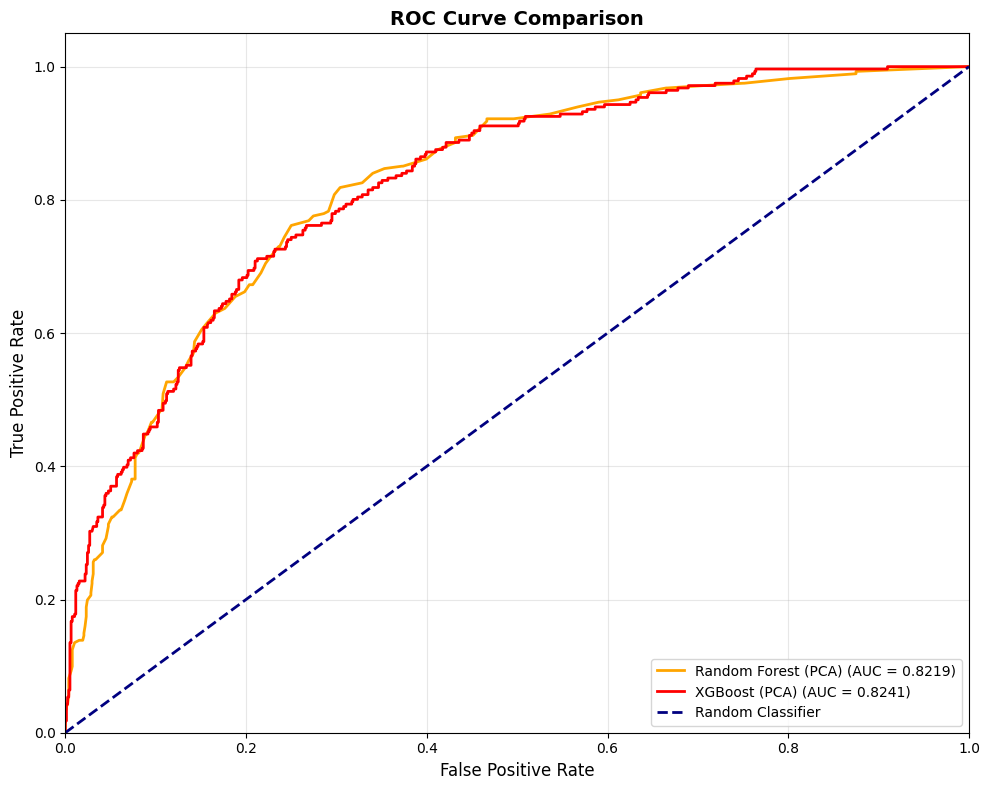

In [11]:
plt.figure(figsize=(10, 8))

models_roc = [
   (y_pred_proba_rf_pca, "Random Forest (PCA)", 'orange'),
   (y_pred_proba_xgb_pca, "XGBoost (PCA)", 'red')
]
for y_pred_proba, model_name, color in models_roc:
   fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
   roc_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


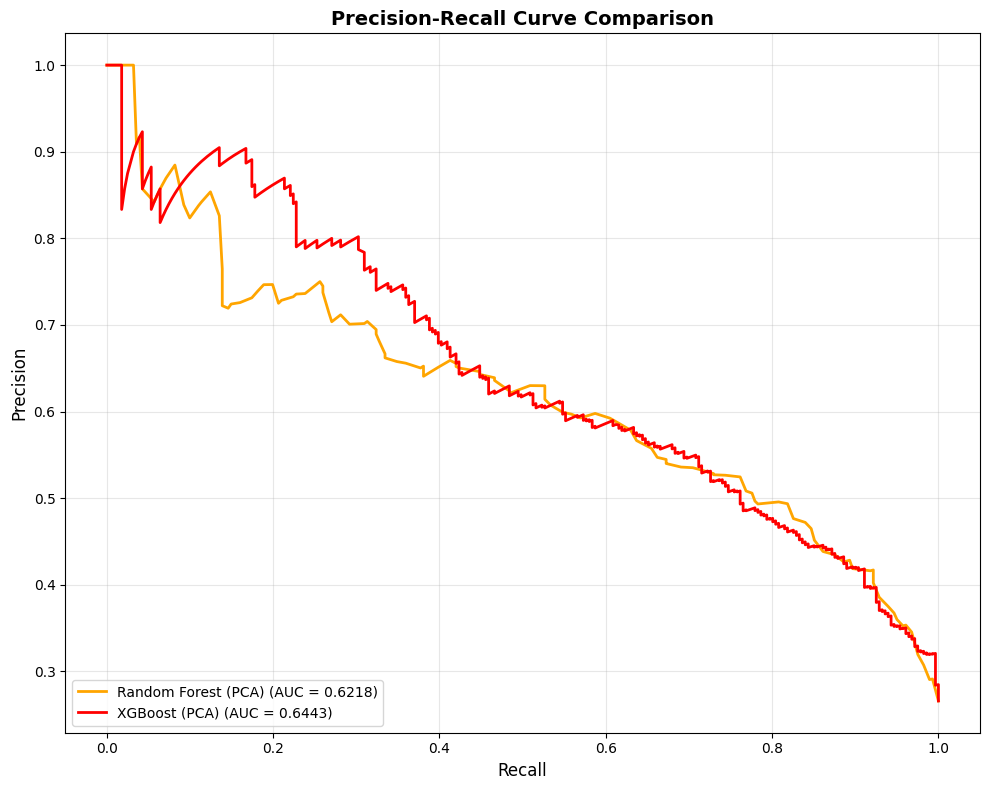

In [12]:
plt.figure(figsize=(10, 8))

for y_pred_proba, model_name, color in models_roc:
   precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
   pr_auc = auc(recall, precision)
   plt.plot(recall, precision, color=color, lw=2, label=f'{model_name} (AUC = {pr_auc:.4f})')


plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
